# Forward Error Correction Bit Error Analysis

In [2]:
from pynq import Overlay
import numpy as np
import xsdfec
import rfsoc_sdfec
from ipywidgets import IntProgress
from IPython.display import display
import time

from helper_functions import *

ol = Overlay('bitstream/fec_ber.bit')

## Configure Encoder & Decoder

In [3]:
# Initialise encoder hardware
e_fec = ol.sd_fec_enc
e_ldpc_params = e_fec.available_ldpc_params()
add_multiple_ldpc_params(e_fec, e_ldpc_params)

# Initialise decoder hardware
d_fec = ol.sd_fec_dec
d_ldpc_params = d_fec.available_ldpc_params()
add_multiple_ldpc_params(d_fec, d_ldpc_params)

def set_ldpc_code(cn):
    e_code_id = e_ldpc_params.index(e_ldpc_params[cn])
    e_ctrl_params = {'id' : 0, 'code' : e_code_id}
    enc_ctrl = create_ctrl_reg(e_ctrl_params)
    enc_length = int(e_fec._code_params.ldpc[e_ldpc_params[cn]]['k'] / 8)

    d_code_id = d_ldpc_params.index(d_ldpc_params[cn])
    d_ctrl_params = {'id' : 0, 
                     'max_iterations' : 32,
                     'term_on_no_change' : 1,
                     'term_on_pass' : 1, 
                     'include_parity_op' : 0,
                     'hard_op' : 1,
                     'code' : d_code_id}
    dec_ctrl = create_ctrl_reg(d_ctrl_params)
    dec_length = d_fec._code_params.ldpc[d_ldpc_params[cn]]['n']
    
    ol.sd_fec_ctrl_encoder.set(enc_ctrl, enc_length)
    ol.sd_fec_ctrl_decoder.set(dec_ctrl, dec_length)

Adding LDPC code parameters to "sd_fec_enc" internal memory.

Status     Code ID    SC Offset  LA Offset  QC Offset  Code Name 
------     ------     ------     ------     ------     ------    
Loaded     0          0          0          0          docsis_short_encode
Loaded     1          2          2          21         docsis_medium_encode
Loaded     2          4          4          54         docsis_long_encode
Loaded     3          6          6          97         docsis_init_ranging_encode
Loaded     4          8          8          112        docsis_fine_ranging_encode
Adding LDPC code parameters to "sd_fec_dec" internal memory.

Status     Code ID    SC Offset  LA Offset  QC Offset  Code Name 
------     ------     ------     ------     ------     ------    
Loaded     0          0          0          0          docsis_short
Loaded     1          2          2          21         docsis_medium
Loaded     2          4          4          54         docsis_long
Loaded     3       

## Measure Bit Error Rate

In [8]:
codes = range(1)
SNRs = [x / 10.0 for x in range(200, 0, -1)]

f = IntProgress(min=0, max=len(codes)*len(SNRs))
display(f)

ol.random_number_generator.set_signal_length(ol.sd_fec_ctrl_encoder.len * 1000)

BERs = []
for cn in codes:
    set_ldpc_code(cn)
    for snr in SNRs:
        ol.awgn_channel.set_snr(snr)
        ol.soft_demodulation.set_scaling(ol.awgn_channel.noise_var, 1)
        ol.random_number_generator.start()
        time.sleep(0.1)
        ber = ol.ber.get_ber()
#         print(ber)
#         print(ol.ber.get_bit_count())
        BERs.append(ber)
        ol.ber.reset()
        f.value += 1

IntProgress(value=0, max=200)

0 200


<function matplotlib.pyplot.show(*args, **kw)>

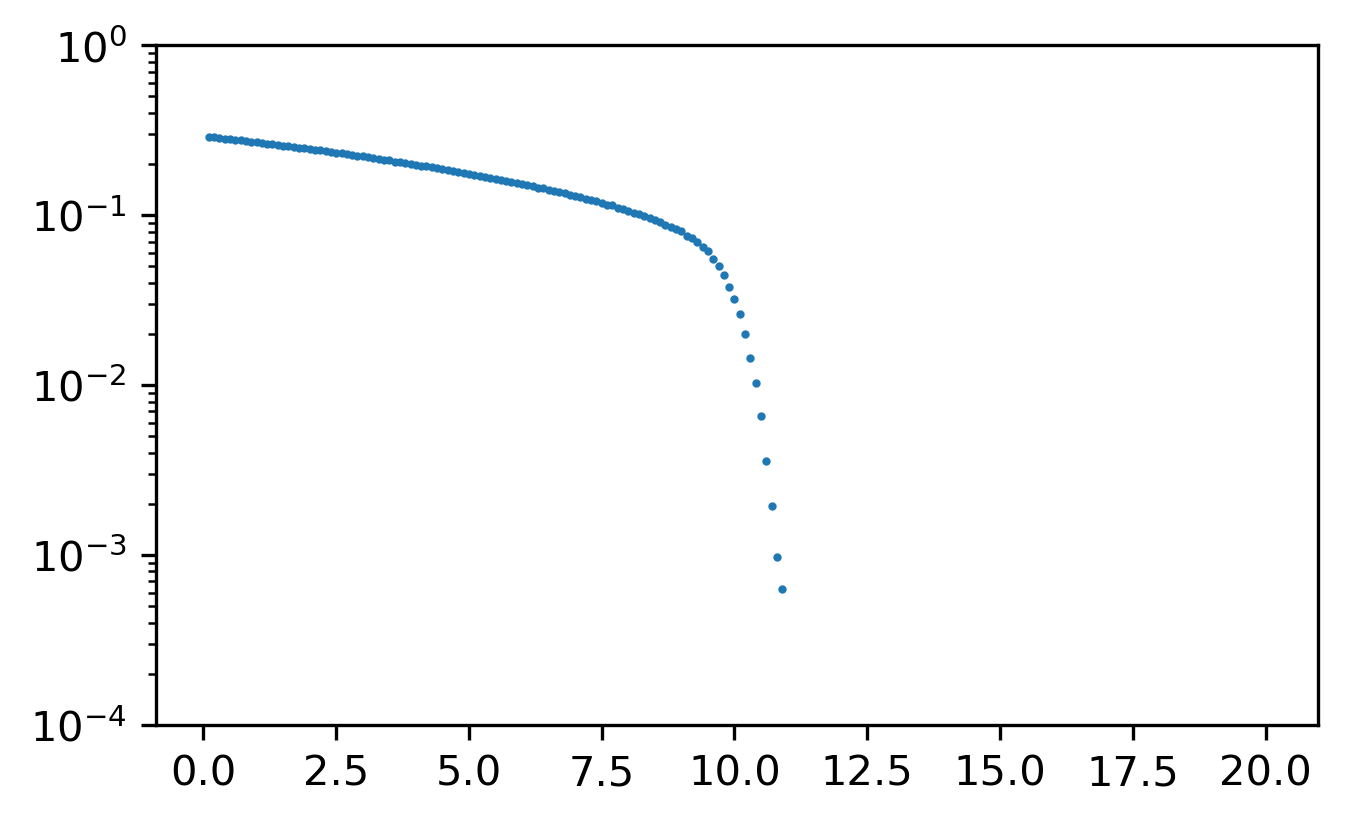

In [9]:
R = len(codes)
L = len(BERs)
for i in range(R):
    start = int(i*(L/R))
    end = int(((i+1)*(L/R)))
    print(start, end)
    plt.scatter(SNRs, BERs[start:end], s=1)
    
plt.yscale('log')
plt.ylim(top = 1, bottom = 0.0001)
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 300
plt.show